# Final Assignment 
## Team : Ethan Setrouk; Paul Augis; Badre Mhiouah; Djoman Danho; Marouane Battach

## Librairies


In [1]:
import pandas as pd
import numpy as np
import random as rd
from sklearn.datasets import make_regression
from sklearn.isotonic import IsotonicRegression
pd.options.mode.chained_assignment = None  
import matplotlib.pyplot as plt
import time
from dateutil.relativedelta import *
from datetime import datetime
from scipy.optimize import minimize
import yfinance as yf

from scipy.cluster.hierarchy import average, leaves_list, dendrogram,fcluster
from scipy.spatial.distance import squareform

## Parametres

In [2]:
#path = r'/Users/djomandanho/Documents/russell1000.csv'
path = 'russell1000.csv'

In [3]:
insample_start_date = '1995-01-01'
insample_end_date = '2005-01-01'
outsample_start_date = '2005-01-01'
outsample_end_date = '2010-01-01'

In [4]:
rebalancing_freq = '1M' 
rebalancing_dates = pd.date_range(start=outsample_start_date, end=outsample_end_date, freq=rebalancing_freq)

In [5]:
kappa = 1
lambd = 13.3
theta = 0.1
transaction_cost = 0.05 

## Data

### Russel1000's index

In [6]:
# data index russel
prices_russell = yf.download('^RUT', start=insample_start_date, end=outsample_end_date)['Adj Close']
df_russell = pd.DataFrame(prices_russell)

df_russell_insample = df_russell.loc[insample_start_date:insample_end_date]
df_russell_outsample = df_russell.loc[outsample_start_date:outsample_end_date]

df_russell_return = df_russell.pct_change().rename(columns={'Adj Close': 'return'})

russell_return_outsample = df_russell_return.loc[outsample_start_date:outsample_end_date]

[*********************100%***********************]  1 of 1 completed


### Russel1000's stocks

In [7]:
data = pd.read_csv(path)
data['index'] = pd.to_datetime(data['index'])
data = data.set_index("index")
data = np.exp(data) - 1 #convert to vanilla returns
df = data.loc[insample_start_date:outsample_end_date]
df = df.dropna(axis=1) #Keep only alive stocks in the index for this period

## Selecting Stocks by clustering

In order to choose the stocks that will compose our portfolio, we will use two methods:

- The first one is to choose N (about 10) securities in a random way


- The second, we will do a russell1000 clustering by defining the correlation as the distance between the clustsers. Then, we will choose one stock per cluster to build our portfolio in order to have a diversified portfolio.

In [8]:
def sharpe_ratio(ts):
    return (ts.mean())/ts.std()

def stock_sr(sub_df):
    index = sharpe_ratio(sub_df).argmax()
    
    return sub_df.columns[index]

def select_stocks(df):
    
    distance = 1 - df.corr()

    avg  = average(squareform(distance))
    ordered_stocks = leaves_list(avg)
    
    threshold = 0.87
    labels = fcluster(avg, threshold, criterion='distance')

    # Show the cluster
    reg_corr = df.corr()
    dic = {}
    for i in set(labels):
        dic[i] = df.columns[labels==i]
    
    stocks = []
    for key,value in dic.items():
        stocks.append(stock_sr(df[value]))
        
    return stocks

In [9]:
selected_stocks = select_stocks(df.loc[insample_start_date:insample_end_date])
N = len(selected_stocks)

df_insample_selected  = df.loc[insample_start_date:insample_end_date,selected_stocks]
df_outsample_selected = df.loc[outsample_start_date:outsample_end_date,selected_stocks]
cov_matrix_selected   = df_insample_selected.cov()
corr_matrix_selected  = df_insample_selected.corr()

In [10]:
print(N)

14


## Random Stock

In [11]:
random_stocks        = list(df.columns[:N])
df_insample_random   = df.loc[insample_start_date:insample_end_date,random_stocks]
df_outsample_random  = df.loc[outsample_start_date:outsample_end_date,random_stocks]
cov_matrix_random    = df_insample_random.cov()
corr_matrix_random   = df_insample_random.corr()

## Backtesting function

In [12]:
def backtest_strategy(dico_return): #dico_return{titre:df_return}
    
    facteur_annnualisation = 252
    dico_backtest = {}
    
    for titre,df_return in dico_return.items():
    
        start_date = df_return.index.min()
        end_date = df_return.index.max()

        df_return = df_return.dropna()
       
        df_return['cum_return'] = (1 + df_return['return']).cumprod() - 1

        total_return = df_return['cum_return'].iloc[-1] - 1  
        annualized_return = (1 + total_return) ** (facteur_annnualisation/len(df_return)) - 1

        dayly_volatility = df_return['return'].std()
        annualized_volatility = df_return['return'].std() * (facteur_annnualisation**0.5)

        sharpe_ratio = annualized_return / annualized_volatility

        cum_returns = (1 + df_return['return']).cumprod() - 1
        running_max = cum_returns.cummax()
        drawdown = cum_returns - running_max
        max_drawdown = drawdown.min()
        
        d = {"df_return":df_return,"start_date":start_date,"end_date":end_date,"total_return":total_return,"annualized_return":annualized_return,"dayly_volatility":dayly_volatility,"annualized_volatility":annualized_volatility,"sharpe_ratio":sharpe_ratio,"max_drawdown":max_drawdown}
        
        dico_backtest[titre] = d
    
        
    #################################################### Afficher les résultats
    print('      ############################## Backtesting ##############################')
    print()
    print(f'                         Start Date: {start_date}')
    print(f'                         End Date  : {end_date}')
    print(f'                         Nb jours  : {len(df_return)}')
    print()
    print()
    for titre,dico in dico_backtest.items():
        print(f'Total Return {titre}: {dico["total_return"]:.2%}')
    print()
    for titre,dico in dico_backtest.items():
        print(f'Annualized Return {titre}: {dico["annualized_return"]:.2%}')
    print()
    for titre,dico in dico_backtest.items():
        print(f'Daily Volatility {titre}: {dico["dayly_volatility"]:.2%}')
    print()
    for titre,dico in dico_backtest.items():
        print(f'Annualized Volatility {titre}: {dico["annualized_volatility"]:.2%}')
    print()
    for titre,dico in dico_backtest.items():
        print(f'Sharpe Ratio {titre}: {dico["sharpe_ratio"]:.2f}')
    print()
    for titre,dico in dico_backtest.items():
        print(f'Max drawdown {titre}: {dico["max_drawdown"]:.2%}')
    print()
    
    ###################################################### Graphs
    
    plt.figure(figsize = (15,6))
    
    for titre,dico in dico_backtest.items():
        plt.plot(dico["df_return"]['cum_return'],lw=0.8,label=titre)
    
    plt.grid(alpha=0.4,linestyle='--')
    plt.title("Performance")
    plt.ylabel('Cumulative Returns (%)')
    plt.xticks(rotation=45)
    plt.legend()

    #################################### Returns
    plt.figure(figsize = (15,6))
    plt.subplot(121)
    
    for titre,dico in dico_backtest.items():
        plt.plot(dico["df_return"]['return'], "-o",label=titre)
    
    plt.title("Return")
    plt.grid(alpha=0.4,linestyle='--')
    plt.xticks(rotation=45)
    plt.legend()

    #################################### Hist Returns
    plt.subplot(122)
    for titre,dico in dico_backtest.items():
        plt.hist(dico["df_return"]['return'], bins=100,label=titre)
        
    plt.title("Distribution return strategy")
    plt.grid(alpha=0.4,linestyle='--')
    plt.legend()
    
    plt.show()

## Turnover analysis function

In [13]:
def turnover(list_date, list_poids):
    
    list_poids = np.array(list_poids)
   
    y = np.vstack(list_poids).T
    
    # plot
    fig, ax = plt.subplots(figsize=(8,4))
    ax.stackplot(list_date, y)
    plt.title("Turnover")
    plt.xlabel("time")
    plt.ylabel("weights")
    plt.show()

# 1- Robust Control 

In [14]:
# Define the objective function
def objective1(w,mus,omega,S):
    return - (mus @ w - kappa * np.sqrt(w @ omega @ w) - 0.5 * lambd * w @ S @ w)

def objective2(w,theta,w_previous,mus,omega,S):
    return - (mus @ w - kappa * np.sqrt(w @ omega @ w) - 0.5 * lambd * w @ S @ w - theta * np.linalg.norm((w - w_previous),1))

def robust_optimization(kappa,lambd,S,omega,mus,objective,*args):
    
    N = len(mus)
    
    #Initialize weights
    w0 = N * [1/N]

    # Define the bounds for w
    bounds = [(0, 1) for i in range(N)]

    # Define the constraints
    cons = [{'type': 'ineq', 'fun':lambda w: np.sum(w) - 1}]
    
    args = args + (mus,omega,S)
    # Solve the optimization problem
    res = minimize(objective, w0, args=args,method='SLSQP', bounds=bounds,constraints=cons)
    return res.x.round(3)

## 1.1 - Static allocation

$$w_{rob}=argmax(\mu^{T}w-\kappa \sqrt{w^T\Omega w}-\frac{\lambda}{2} w^T \Sigma w)$$

$$s.t.  \sum_{i=1}^{N} w_{i}=1$$

In [15]:
def robust_static_allocation(cov_matrix, df_insample, df_outsample):
    
    S = cov_matrix.to_numpy()
    omega = np.diag(S.diagonal(0,0,1))

    mus = df_insample.mean()
    
    w_rob = robust_optimization(kappa,lambd,S,omega,mus,objective1)

    insample_rob_return = df_insample @ w_rob
    outsample_rob_return = df_outsample @ w_rob

    insample_rob_perf = (1 + insample_rob_return).cumprod() - 1
    outsample_rob_perf = (1 + outsample_rob_return).cumprod() - 1

    ptf_return_rob_statique = pd.DataFrame(outsample_rob_return, columns=["return"])
    ptf_return_rob_statique.index = pd.Index([d.date() for d in ptf_return_rob_statique.index])
    
    return ptf_return_rob_statique

In [16]:
ptf_return_rob_statique_random = robust_static_allocation(cov_matrix_random, df_insample_random, df_outsample_random)
ptf_return_rob_statique_selected = robust_static_allocation(cov_matrix_selected, df_insample_selected, df_outsample_selected)

/var/folders/s2/myvbmwhd6_q3sbxkqwg5whp80000gn/T/ipykernel_24427/3911208565.py:16: RuntimeWarning: invalid value encountered in double_scalars
  annualized_return = (1 + total_return) ** (facteur_annnualisation/len(df_return)) - 1


      ############################## Backtesting ##############################

                         Start Date: 2005-01-03
                         End Date  : 2009-12-31
                         Nb jours  : 1259


Total Return Russel1000: -104.02%
Total Return robust static (random stocks): -74.12%
Total Return robust static ( selected stocks): -58.71%

Annualized Return Russel1000: nan%
Annualized Return robust static (random stocks): -23.71%
Annualized Return robust static ( selected stocks): -16.23%

Daily Volatility Russel1000: 1.88%
Daily Volatility robust static (random stocks): 1.39%
Daily Volatility robust static ( selected stocks): 1.66%

Annualized Volatility Russel1000: 29.83%
Annualized Volatility robust static (random stocks): 22.02%
Annualized Volatility robust static ( selected stocks): 26.37%

Sharpe Ratio Russel1000: nan
Sharpe Ratio robust static (random stocks): -1.08
Sharpe Ratio robust static ( selected stocks): -0.62

Max drawdown Russel1000: -78.66%
Max dr

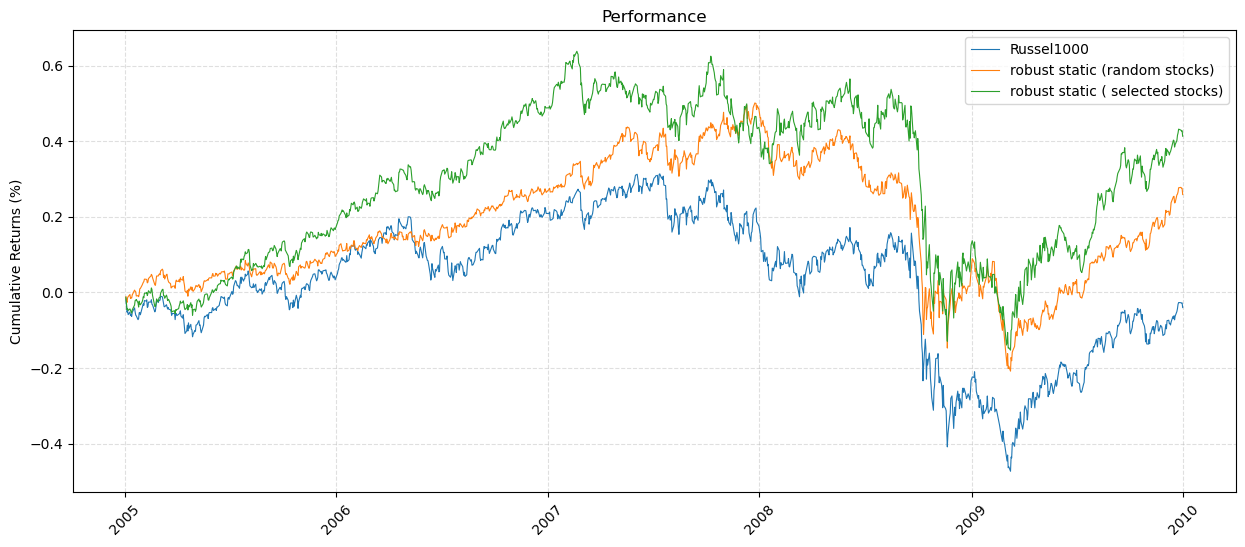

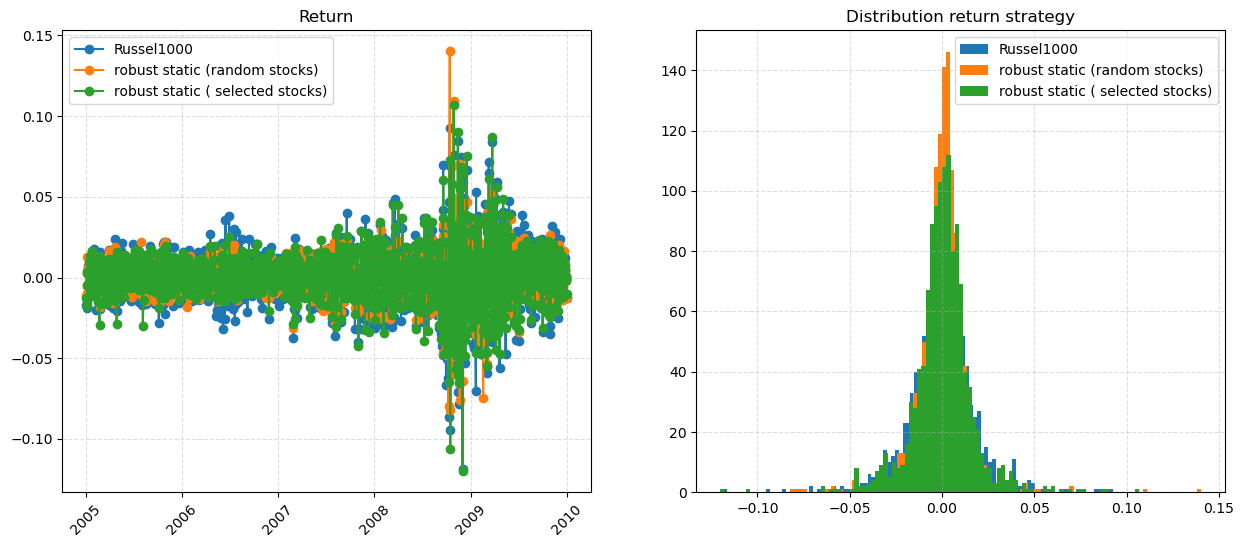

In [17]:
backtest_strategy({ "Russel1000":russell_return_outsample,
                    "robust static (random stocks)":ptf_return_rob_statique_random,
                    "robust static ( selected stocks)":ptf_return_rob_statique_selected})

**- We observe that our static allocation superforms the russell1000 index.**

**- We also observe that the clustering method of stock selection is much better than the random method**

## 1.2 - Dynamic allocation

$$w_{rob}=argmax(\mu^{T}w-\kappa \sqrt{w^T\Omega w}-\frac{\lambda}{2} w^T \Sigma w - \theta \sum_{i=1}^{N} |w - w_{previous}|)$$

In [18]:
def robust_dynamic_allocation(N,df,rebalancing_dates):

    rebalancing_weights = [np.zeros(N)]
    w_previous = rebalancing_weights[0]

    strategy_returns = pd.DataFrame(np.zeros(df.shape[0]),index=df.index,columns=['Returns'])

    start_time = time.time()

    for i,date in enumerate(rebalancing_dates[:-1]):

        current_data = df.loc[rebalancing_dates[i]:rebalancing_dates[i + 1]]
        current_date_range = current_data.index

        #stock selection
        stocks = current_data.columns[:N]

        current_data = current_data[stocks]

        S = current_data.cov().to_numpy()
        mus = current_data.mean(axis=0)

        omega = np.diag(S.diagonal(0,0,1))

        #Optimize portfolio with aversion to turnover
        #w_rob = robust_optimization(kappa,lambd,S,omega,mus,objective2,theta,w_previous)
        
        w_rob = robust_optimization(kappa,lambd,S,omega,mus,objective1)

        returns = current_data.multiply(w_previous)

        strategy_returns.loc[current_date_range,'Returns'] = (current_data @ w_previous).values

        w_previous = w_rob

        rebalancing_weights.append(w_rob)
        print(i,':',date.strftime('%Y-%m-%d'),' ',rebalancing_dates[i + 1].strftime('%Y-%m-%d'),' ',sorted(w_rob)[::-1][:5])  

    #Last period
    current_data = df.loc[str(rebalancing_dates[-1]):] 
    stocks = current_data.columns[:N]
    current_data = current_data[stocks]

    strategy_returns.loc[str(rebalancing_dates[-1]):,'Returns'] = (current_data @ w_previous).values

    print(f'Computing time : {time.time() - start_time:.2f}s')
    
    return strategy_returns, rebalancing_weights

In [19]:
strategy_returns_random, rebalancing_weights_rob_random = robust_dynamic_allocation(N,df_outsample_random,rebalancing_dates)

/var/folders/s2/myvbmwhd6_q3sbxkqwg5whp80000gn/T/ipykernel_24427/1310281175.py:12: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  current_data = df.loc[rebalancing_dates[i]:rebalancing_dates[i + 1]]


0 : 2005-01-31   2005-02-28   [0.256, 0.15, 0.13, 0.115, 0.086]
1 : 2005-02-28   2005-03-31   [0.651, 0.087, 0.07, 0.049, 0.046]
2 : 2005-03-31   2005-04-30   [0.384, 0.358, 0.133, 0.056, 0.024]
3 : 2005-04-30   2005-05-31   [0.205, 0.15, 0.14, 0.109, 0.086]
4 : 2005-05-31   2005-06-30   [0.251, 0.249, 0.247, 0.063, 0.057]
5 : 2005-06-30   2005-07-31   [0.24, 0.17, 0.136, 0.119, 0.089]
6 : 2005-07-31   2005-08-31   [0.353, 0.18, 0.109, 0.079, 0.075]
7 : 2005-08-31   2005-09-30   [0.633, 0.067, 0.063, 0.057, 0.044]
8 : 2005-09-30   2005-10-31   [0.204, 0.197, 0.128, 0.086, 0.071]
9 : 2005-10-31   2005-11-30   [0.489, 0.146, 0.132, 0.101, 0.093]
10 : 2005-11-30   2005-12-31   [0.172, 0.149, 0.115, 0.103, 0.083]
11 : 2005-12-31   2006-01-31   [0.151, 0.118, 0.116, 0.11, 0.103]
12 : 2006-01-31   2006-02-28   [0.202, 0.179, 0.17, 0.106, 0.101]
13 : 2006-02-28   2006-03-31   [0.207, 0.188, 0.115, 0.09, 0.085]
14 : 2006-03-31   2006-04-30   [0.211, 0.102, 0.095, 0.092, 0.091]
15 : 2006-04-30 

In [20]:
strategy_returns_selected, rebalancing_weights_rob_selected = robust_dynamic_allocation(N,df_outsample_selected,rebalancing_dates)

0 : 2005-01-31   2005-02-28   [0.178, 0.169, 0.125, 0.124, 0.094]
1 : 2005-02-28   2005-03-31   [0.302, 0.206, 0.141, 0.1, 0.067]


/var/folders/s2/myvbmwhd6_q3sbxkqwg5whp80000gn/T/ipykernel_24427/1310281175.py:12: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  current_data = df.loc[rebalancing_dates[i]:rebalancing_dates[i + 1]]


2 : 2005-03-31   2005-04-30   [0.397, 0.226, 0.095, 0.067, 0.063]
3 : 2005-04-30   2005-05-31   [0.208, 0.158, 0.111, 0.107, 0.096]
4 : 2005-05-31   2005-06-30   [0.212, 0.16, 0.118, 0.106, 0.105]
5 : 2005-06-30   2005-07-31   [0.207, 0.203, 0.18, 0.136, 0.077]
6 : 2005-07-31   2005-08-31   [0.275, 0.165, 0.159, 0.084, 0.077]
7 : 2005-08-31   2005-09-30   [0.239, 0.168, 0.127, 0.086, 0.079]
8 : 2005-09-30   2005-10-31   [0.233, 0.2, 0.114, 0.108, 0.1]
9 : 2005-10-31   2005-11-30   [0.258, 0.252, 0.075, 0.074, 0.067]
10 : 2005-11-30   2005-12-31   [0.309, 0.154, 0.146, 0.09, 0.071]
11 : 2005-12-31   2006-01-31   [0.197, 0.174, 0.126, 0.109, 0.079]
12 : 2006-01-31   2006-02-28   [0.373, 0.151, 0.147, 0.114, 0.075]
13 : 2006-02-28   2006-03-31   [0.169, 0.136, 0.134, 0.115, 0.1]
14 : 2006-03-31   2006-04-30   [0.265, 0.179, 0.089, 0.086, 0.067]
15 : 2006-04-30   2006-05-31   [0.551, 0.128, 0.086, 0.072, 0.057]
16 : 2006-05-31   2006-06-30   [0.209, 0.187, 0.162, 0.151, 0.081]
17 : 2006-06

In [21]:
ptf_return_rob_dynamique_random = strategy_returns_random.rename(columns={'Returns': 'return'}).loc[outsample_start_date:outsample_end_date]
ptf_return_rob_dynamique_random.index = pd.Index([d.date() for d in ptf_return_rob_dynamique_random.index])

ptf_return_rob_dynamique_selected = strategy_returns_selected.rename(columns={'Returns': 'return'}).loc[outsample_start_date:outsample_end_date]
ptf_return_rob_dynamique_selected.index = pd.Index([d.date() for d in ptf_return_rob_dynamique_selected.index])

      ############################## Backtesting ##############################

                         Start Date: 2005-01-03
                         End Date  : 2009-12-31
                         Nb jours  : 1259


Total Return Russel1000: -104.02%
Total Return robust dynamic (random stocks): -97.75%
Total Return robust dynamic (selected stocks): -79.07%
Total Return robust static (random stocks) : -74.12%
Total Return robust static (selected stocks): -58.71%

Annualized Return Russel1000: nan%
Annualized Return robust dynamic (random stocks): -53.19%
Annualized Return robust dynamic (selected stocks): -26.88%
Annualized Return robust static (random stocks) : -23.71%
Annualized Return robust static (selected stocks): -16.23%

Daily Volatility Russel1000: 1.88%
Daily Volatility robust dynamic (random stocks): 1.28%
Daily Volatility robust dynamic (selected stocks): 1.27%
Daily Volatility robust static (random stocks) : 1.39%
Daily Volatility robust static (selected stocks): 1.66%


/var/folders/s2/myvbmwhd6_q3sbxkqwg5whp80000gn/T/ipykernel_24427/3911208565.py:16: RuntimeWarning: invalid value encountered in double_scalars
  annualized_return = (1 + total_return) ** (facteur_annnualisation/len(df_return)) - 1


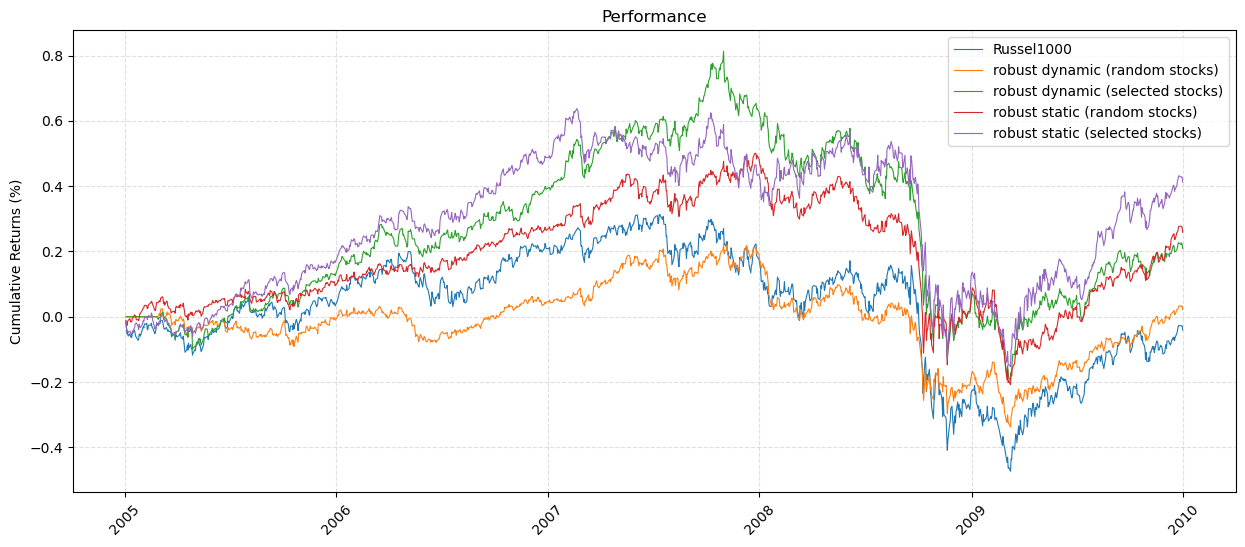

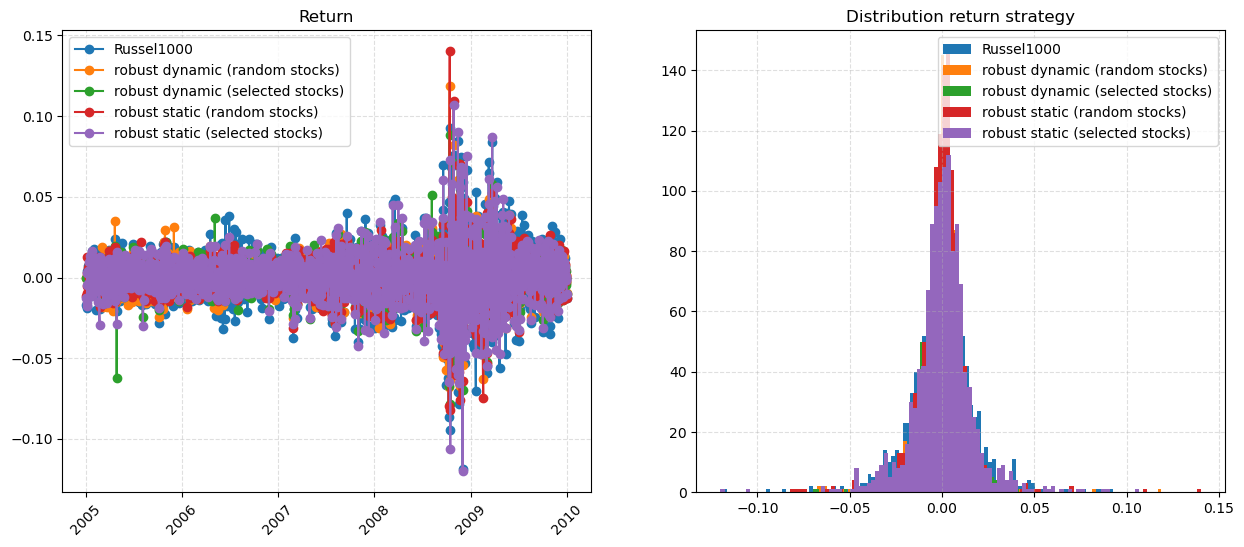

In [22]:
backtest_strategy({"Russel1000":russell_return_outsample,
                   "robust dynamic (random stocks)":ptf_return_rob_dynamique_random,
                   "robust dynamic (selected stocks)":ptf_return_rob_dynamique_selected,
                   "robust static (random stocks) ":ptf_return_rob_statique_random,
                   "robust static (selected stocks)":ptf_return_rob_statique_selected})

**- We observe that the dynamic allocation is better than the static allocation.**

**- We also notice that the selection by clustering is better.**

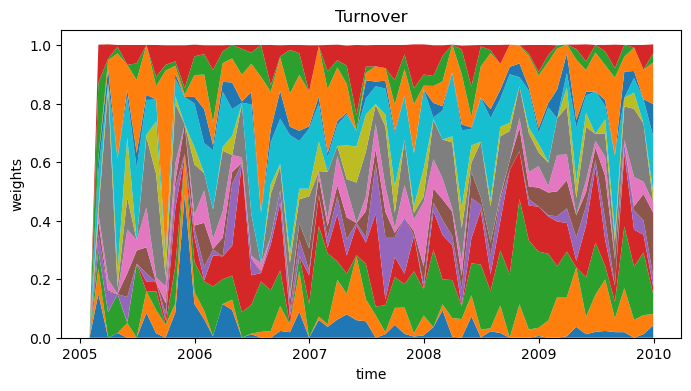

In [23]:
##################################### Plot turnover random stocks #######################
turnover(rebalancing_dates, rebalancing_weights_rob_random)

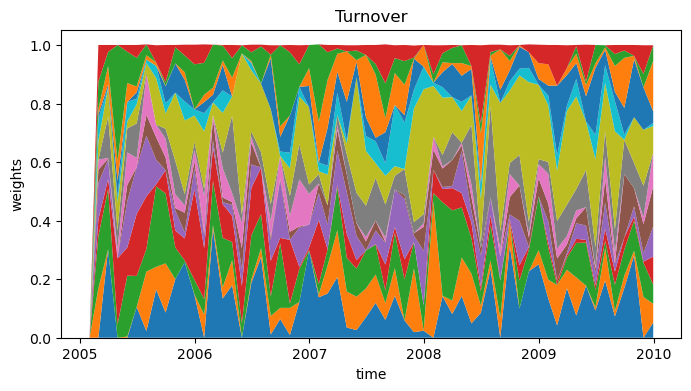

In [24]:
##################################### Plot turnover selected stocks #######################
turnover(rebalancing_dates, rebalancing_weights_rob_selected)

**For both portfolios (randomly selected securities and clustering), we have a low turnover, which lowers transaction costs.**

# 2- Covariance Matrix Filtering

### Clipping Method

In [25]:
#define lambdamax used for the clipping
def lamda_max(N,T,sigma):
    return (sigma**2) * (1 + N/T + 2*np.sqrt(N/T))

# Compute the clipping correlation matrix
def corr_clipping (N,T,corr_matrix):
    
    """Clipping based on correlation matrix"""
    #sigma_clipping = 1
    eigenvalues,eigenvector = np.linalg.eig(corr_matrix)
    sigma_clipping = 1-max(eigenvalues)/N
    lamdamax = lamda_max(N, T, sigma_clipping)
    small_eigenvalues = np.array([elem for elem in eigenvalues if elem < lamdamax ])
    mean_small= np.mean(small_eigenvalues)
    diag_clipping = np.diag([elem if elem > lamdamax else mean_small for elem in eigenvalues])
    corr_clipping = eigenvector.T @ diag_clipping @ eigenvector
    
    return corr_clipping

# Compute the clipping covariance matrix
def cov_clipping(N,T,corr_matrix,var_matrix):
    
    # calculation of the adjusted corrclipping coefficient
    corrclipping = corr_clipping(N,T, corr_matrix)
    diag_corrclipping = np.diag(np.diag(corrclipping))
    diag_corrclipping_inv = np.linalg.inv(diag_corrclipping)
    corrclipping_adj = diag_corrclipping_inv @ corrclipping @ diag_corrclipping_inv
    covclipping = np.sqrt(var_matrix) @ corrclipping_adj @ np.sqrt(var_matrix)
    
    return covclipping

###  Cross Validation

In [26]:
#using cross validation

def lambdaCV(data, index_in_list,index_out_list):
    
    #return the lambda_CV for only one cross validation
    data_in = data.iloc[index_in_list]
    data_out = data.iloc[index_out_list]
    cov_matrix_in = np.cov(data_in.T, bias=True)
    cov_matrix_out = np.cov(data_out.T, bias=True)
    eigenvalues_in,eigenvectors_in = np.linalg.eig(cov_matrix_in)
    lambdaCV = eigenvectors_in.T @ cov_matrix_out @ eigenvectors_in
    
    return np.diag(lambdaCV)

def lambda_CV_moy(nbCV,data):
    
    #applied on the insample data for nbCV Cross validation:
    
    lambda_list = []
    size_in_CV = int(0.7*data.shape[0])
    listdata = range(data.shape[0])
    
    for i in range(nbCV):
        index_in_list = rd.sample(listdata,size_in_CV)
        index_out_list =[elem for elem in listdata if not elem in index_in_list]
        lambda_CV = lambdaCV(data, index_in_list, index_out_list)
        lambda_list.append(lambda_CV)
        
    lambda_list=np.array(lambda_list)
    data_CV=pd.DataFrame(lambda_list)
        
    return np.array(data_CV.mean(axis=0))


def lambda_CV_iso(nbCV,data):
    
    #Computation of lambda_in
    cov_matrix = np.cov(data.T, bias=True)
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

    
    #Retrieval of lambda_Cross validation
    lambdaCross = lambda_CV_moy(nbCV,data)
    iso_reg = IsotonicRegression().fit(eigenvalues,lambdaCross )
    lambda_iso=np.diag(iso_reg.predict(eigenvalues))
    
    return lambda_iso, eigenvalues, eigenvectors
        
def cov_matrix_CV(data,nbCV=100):
    lambda_iso, eigenvalues, eigenvectors = lambda_CV_iso(nbCV,data)
    cov_CV= eigenvectors @ lambda_iso @ eigenvectors.T
    return cov_CV



###  Markowitz Optimisation

In [27]:
def markowitz_optimization(objective,*args):
    
    N = len(args[1])
    
    #Initialize weights
    w0 = N * [1/N]

    # Define the bounds for w
    bounds = [(0, 1) for i in range(N)]

    # Define the constraints
    cons = [{'type': 'eq', 'fun':lambda w: np.sum(w) - 1}]

    # Solve the optimization problem
    res = minimize(objective, w0, args=args,method='SLSQP', bounds=bounds,constraints=cons)
    return res.x.round(3)

In [28]:
def getweights(data,objective,lambd,method="clipping"):
    N = len(data.columns)
   
    T= len(data.index)
    mu = data.mean()
    if method == "clipping":
        cov = data.cov().to_numpy()
        corr= data.corr().to_numpy()
        var_matrix=np.diag(np.diag(cov))
        Sigma = cov_clipping(N,T,corr,var_matrix)
    if method == "cv":
        Sigma = cov_matrix_CV(data)
        
    w= markowitz_optimization(objective,Sigma,mu,lambd)
    return w

def getweights_dynamic(data,objective,lambd,c,wprevious,method="clipping"):
    N = len(data.columns)
    
    T= len(data.index)
    mu = data.mean()
    if method == "clipping":
        cov = data.cov().to_numpy()
        corr= data.corr().to_numpy()
        var_matrix=np.diag(np.diag(cov))
        Sigma = cov_clipping(N,T,corr,var_matrix)
    if method == "cv":
        Sigma = cov_matrix_CV(data)
        
    w= markowitz_optimization(objective,Sigma,mu,lambd,c,wprevious)
    return w

def getreturns(data_in,data_out,objective,lambd,method="clipping"):
    w = getweights(data_in,objective,lambd,method=method)
    returns = data_out @ w
    return returns

## 2.1 - Static Allocation

In [29]:
#Objective Function used for Markowitz optimisation
def objective3(w,Sigma,mu,lambd):
    return - (mu @ w - 0.5 * lambd * w @ Sigma @ w)

In [30]:
def static_allocation_filtering(df_insample,df_outsample):

    # Compute Clipping weights

    w_clipping = getweights(df_insample,objective3,lambd,method="clipping")
    w_cv = getweights(df_insample,objective3,lambd,method="cv")

    #Cumulative Return

    insample_clipping_return = df_insample @ w_clipping
    outsample_clipping_return = df_outsample @ w_clipping

    insample_cv_return = df_insample @ w_cv
    outsample_cv_return = df_outsample @ w_cv

    ptf_return_clipping_statique = pd.DataFrame(outsample_clipping_return, columns=["return"])
    ptf_return_clipping_statique.index = pd.Index([d.date() for d in ptf_return_clipping_statique.index])

    ptf_return_cv_statique = pd.DataFrame(outsample_cv_return, columns=["return"])
    ptf_return_cv_statique.index = pd.Index([d.date() for d in ptf_return_cv_statique.index])

    print(w_clipping)
    print(w_cv)
    return ptf_return_clipping_statique, ptf_return_cv_statique

In [31]:
ptf_return_clipping_statique_random, ptf_return_cv_statique_random = static_allocation_filtering(df_insample_random,df_outsample_random)
ptf_return_clipping_statique_selected, ptf_return_cv_statique_selected = static_allocation_filtering(df_insample_selected,df_outsample_selected)

[0.043 0.075 0.087 0.09  0.067 0.033 0.107 0.053 0.018 0.066 0.101 0.111
 0.038 0.111]
[0.073 0.035 0.106 0.117 0.026 0.005 0.1   0.084 0.022 0.117 0.069 0.097
 0.037 0.111]
[0.099 0.133 0.101 0.136 0.    0.092 0.083 0.102 0.033 0.043 0.054 0.027
 0.06  0.037]
[0.103 0.111 0.104 0.131 0.    0.101 0.095 0.095 0.038 0.036 0.037 0.015
 0.053 0.081]


      ############################## Backtesting ##############################

                         Start Date: 2005-01-03
                         End Date  : 2009-12-31
                         Nb jours  : 1259


Total Return Russel1000: -104.02%
Total Return clipping static (random): -42.00%
Total Return CV static (random): -61.05%
Total Return clipping static (selected): -62.22%
Total Return CV static (selected): -61.43%

Annualized Return Russel1000: nan%
Annualized Return clipping static (random): -10.33%
Annualized Return CV static (random): -17.20%
Annualized Return clipping static (selected): -17.70%
Annualized Return CV static (selected): -17.36%

Daily Volatility Russel1000: 1.88%
Daily Volatility clipping static (random): 1.50%
Daily Volatility CV static (random): 1.46%
Daily Volatility clipping static (selected): 1.57%
Daily Volatility CV static (selected): 1.54%

Annualized Volatility Russel1000: 29.83%
Annualized Volatility clipping static (random): 23.81%
Annualiz

/var/folders/s2/myvbmwhd6_q3sbxkqwg5whp80000gn/T/ipykernel_24427/3911208565.py:16: RuntimeWarning: invalid value encountered in double_scalars
  annualized_return = (1 + total_return) ** (facteur_annnualisation/len(df_return)) - 1


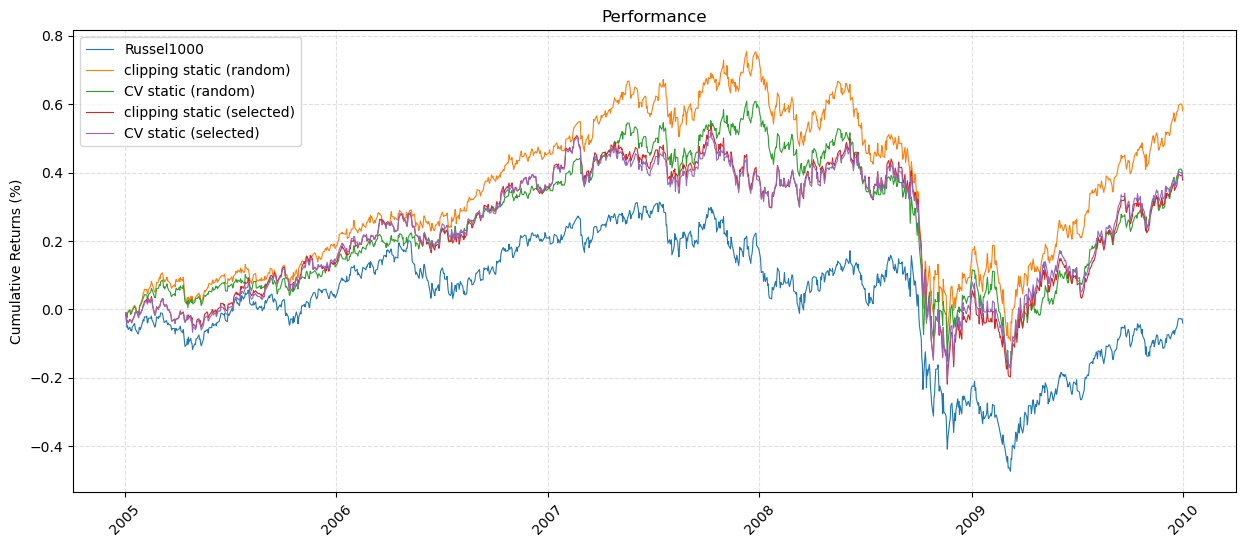

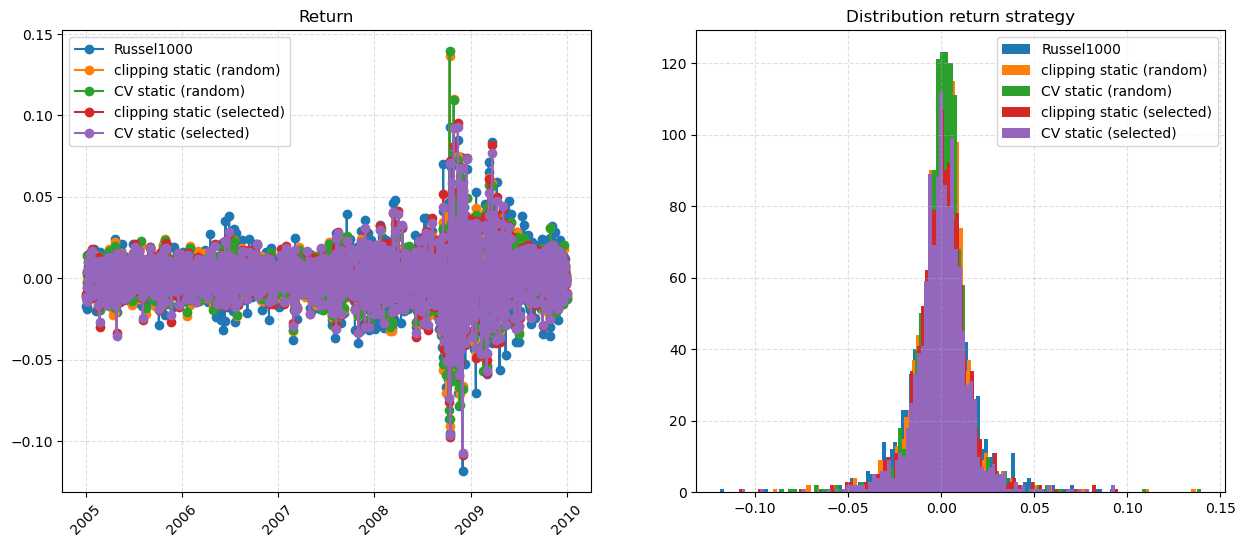

In [32]:
backtest_strategy({ "Russel1000":russell_return_outsample,
                    "clipping static (random)":ptf_return_clipping_statique_random,
                    "CV static (random)":ptf_return_cv_statique_random,
                    "clipping static (selected)":ptf_return_clipping_statique_selected,
                    "CV static (selected)":ptf_return_cv_statique_selected
                  
                  })

**- We observe that the clipping method is slightly better than cross validation method.** 

**- Once again, clustering outperforms the random method, let's analyse the dynamic allocation for the clustered portfolio only.**

## 2.2 - Dynamic allocation

$$w_{MVO}=argmax(\mu^{T}w-\frac{\lambda}{2} w^T \Sigma w - c\sum_{i=1}^{N} |w - w_{previous}|)$$

In [33]:
def dynamic_allocation(data,start_in,end_in,start_out,end_out,rebalancing_freq, objective,objective_cost,lambd,c,method= "clipping"):
     
     
    new_data_list =[]
    start_data_in = pd.to_datetime(start_in).tz_localize(tz='UTC')
    end_data_in = pd.to_datetime(end_in).tz_localize('UTC')
    #T= datetime.strptime(end_data_in,"%Y-%M-%d") - datetime.strptime(start_data_in,"%Y-%M-%d")
    T = end_data_in - start_data_in
    start_data_out = pd.to_datetime(start_out).tz_localize('UTC')
    end_data_out = pd.to_datetime(end_out).tz_localize('UTC')
    rebalancing_dates_range = pd.date_range(start=start_out,end=end_out,tz='UTC',freq=rebalancing_freq)
    
    
    list_weights = []
    
    for i,date in enumerate(rebalancing_dates_range):
        current_data_in = data.loc[start_data_in:end_data_in,:].dropna(axis=1)
        current_data_out= data.loc[start_data_out:rebalancing_dates_range[i],:]
   
        if i==0:
            w= getweights(current_data_in,objective,lambd,method=method)
        else:
            #w= getweights_dynamic(current_data_in,objective_cost,lambd,c,wprevious,method=method)
            w= getweights(current_data_in,objective,lambd,method=method)
        returns= current_data_out @ w
        wprevious=w
        #returns= getreturns(current_data_in,current_data_out,objective_cost,lambd,method=method)
        new_data_list.append(returns)
        end_data_in = rebalancing_dates_range[i]
        start_data_in = end_data_in-T
        start_data_out = end_data_in
        #start_data_in = datetime.strftime(start_data_in,"%Y-%M-%d")
        
        list_weights.append(w)
        print(date.strftime("%Y-%m-%d"), " : ", w)
        
    return (pd.concat(new_data_list)), list_weights
        
 

In [34]:
def objective4(w,Sigma,mu,lambd,c,w_previous):
    return - (mu @ w  - 0.5 * lambd * w @ Sigma @ w - theta * np.linalg.norm((w - w_previous),1))


In [35]:
rendements_clipping, list_weights_clipping  = dynamic_allocation(data[selected_stocks],insample_start_date,insample_end_date,outsample_start_date,outsample_end_date,
                                                                rebalancing_freq,objective3,objective4,lambd,transaction_cost,method= "clipping")


2005-01-31  :  [0.099 0.133 0.101 0.136 0.    0.092 0.083 0.102 0.033 0.043 0.054 0.027
 0.06  0.037]
2005-02-28  :  [0.099 0.11  0.101 0.112 0.005 0.097 0.093 0.088 0.042 0.053 0.071 0.008
 0.064 0.055]
2005-03-31  :  [0.065 0.101 0.134 0.306 0.    0.085 0.065 0.057 0.013 0.042 0.048 0.035
 0.048 0.   ]
2005-04-30  :  [0.098 0.132 0.103 0.148 0.001 0.101 0.091 0.105 0.027 0.041 0.062 0.013
 0.054 0.023]
2005-05-31  :  [0.062 0.103 0.114 0.342 0.    0.061 0.05  0.101 0.005 0.04  0.05  0.021
 0.051 0.003]
2005-06-30  :  [0.075 0.126 0.111 0.18  0.007 0.109 0.096 0.083 0.022 0.055 0.045 0.048
 0.043 0.   ]
2005-07-31  :  [0.088 0.132 0.095 0.123 0.    0.1   0.114 0.098 0.025 0.055 0.07  0.022
 0.052 0.027]
2005-08-31  :  [0.088 0.127 0.099 0.116 0.    0.109 0.11  0.107 0.048 0.061 0.033 0.018
 0.049 0.034]
2005-09-30  :  [0.086 0.126 0.105 0.15  0.001 0.115 0.114 0.1   0.023 0.063 0.038 0.029
 0.051 0.   ]
2005-10-31  :  [0.089 0.119 0.105 0.17  0.    0.123 0.094 0.089 0.028 0.052 0.045 

In [36]:
rendements_cv,list_weights_cv = dynamic_allocation(data[selected_stocks],insample_start_date,insample_end_date,outsample_start_date,outsample_end_date,
                                                    rebalancing_freq,objective3,objective4,lambd,transaction_cost,method= "cv")


2005-01-31  :  [0.104 0.111 0.106 0.136 0.    0.098 0.095 0.096 0.04  0.035 0.034 0.012
 0.054 0.082]
2005-02-28  :  [0.106 0.112 0.104 0.125 0.    0.096 0.098 0.098 0.037 0.042 0.034 0.014
 0.052 0.082]
2005-03-31  :  [0.103 0.117 0.104 0.127 0.    0.096 0.1   0.091 0.04  0.038 0.035 0.012
 0.051 0.086]
2005-04-30  :  [0.111 0.121 0.105 0.129 0.    0.1   0.102 0.092 0.03  0.041 0.029 0.01
 0.049 0.081]
2005-05-31  :  [0.104 0.115 0.106 0.133 0.    0.099 0.095 0.092 0.033 0.045 0.029 0.017
 0.054 0.079]
2005-06-30  :  [0.102 0.119 0.106 0.133 0.    0.109 0.092 0.092 0.03  0.048 0.024 0.013
 0.052 0.08 ]
2005-07-31  :  [0.106 0.124 0.104 0.123 0.    0.101 0.096 0.092 0.034 0.041 0.026 0.017
 0.054 0.083]
2005-08-31  :  [0.1   0.125 0.103 0.132 0.    0.107 0.103 0.09  0.023 0.042 0.018 0.021
 0.051 0.084]
2005-09-30  :  [0.105 0.12  0.104 0.132 0.    0.112 0.103 0.088 0.02  0.044 0.016 0.019
 0.05  0.087]
2005-10-31  :  [0.099 0.124 0.1   0.124 0.    0.115 0.098 0.084 0.033 0.043 0.022 0

## Backtesting

In [37]:
ptf_return_cv_dynamique = pd.DataFrame(rendements_cv, columns=["return"])
ptf_return_cv_dynamique.index = pd.Index([d.date() for d in ptf_return_cv_dynamique.index])

ptf_return_clipping_dynamique = pd.DataFrame(rendements_clipping, columns=["return"])
ptf_return_clipping_dynamique.index = pd.Index([d.date() for d in ptf_return_clipping_dynamique.index])


      ############################## Backtesting ##############################

                         Start Date: 2005-01-03
                         End Date  : 2009-12-31
                         Nb jours  : 1259


Total Return Russel1000: -104.02%
Total Return clipping dynamique (selected): -74.73%
Total Return CV dynamique (selected): -72.25%
Total Return clipping static (selected): -62.22%
Total Return CV static (selected): -61.43%

Annualized Return Russel1000: nan%
Annualized Return clipping dynamique (selected): -24.09%
Annualized Return CV dynamique (selected): -22.65%
Annualized Return clipping static (selected): -17.70%
Annualized Return CV static (selected): -17.36%

Daily Volatility Russel1000: 1.88%
Daily Volatility clipping dynamique (selected): 1.57%
Daily Volatility CV dynamique (selected): 1.41%
Daily Volatility clipping static (selected): 1.57%
Daily Volatility CV static (selected): 1.54%

Annualized Volatility Russel1000: 29.83%
Annualized Volatility clipping dy

/var/folders/s2/myvbmwhd6_q3sbxkqwg5whp80000gn/T/ipykernel_24427/3911208565.py:16: RuntimeWarning: invalid value encountered in double_scalars
  annualized_return = (1 + total_return) ** (facteur_annnualisation/len(df_return)) - 1


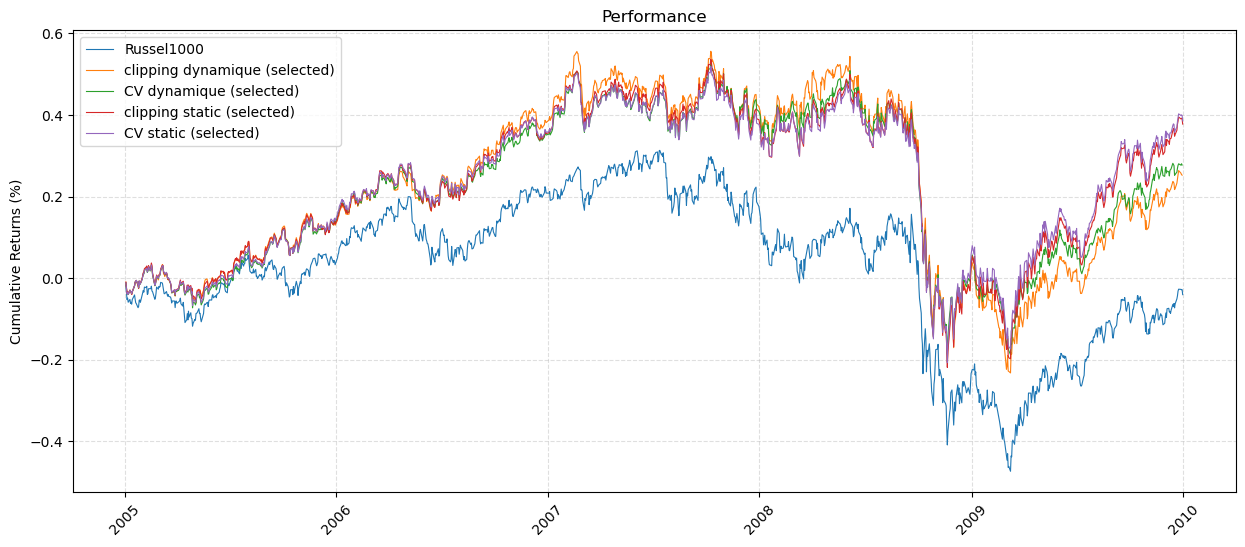

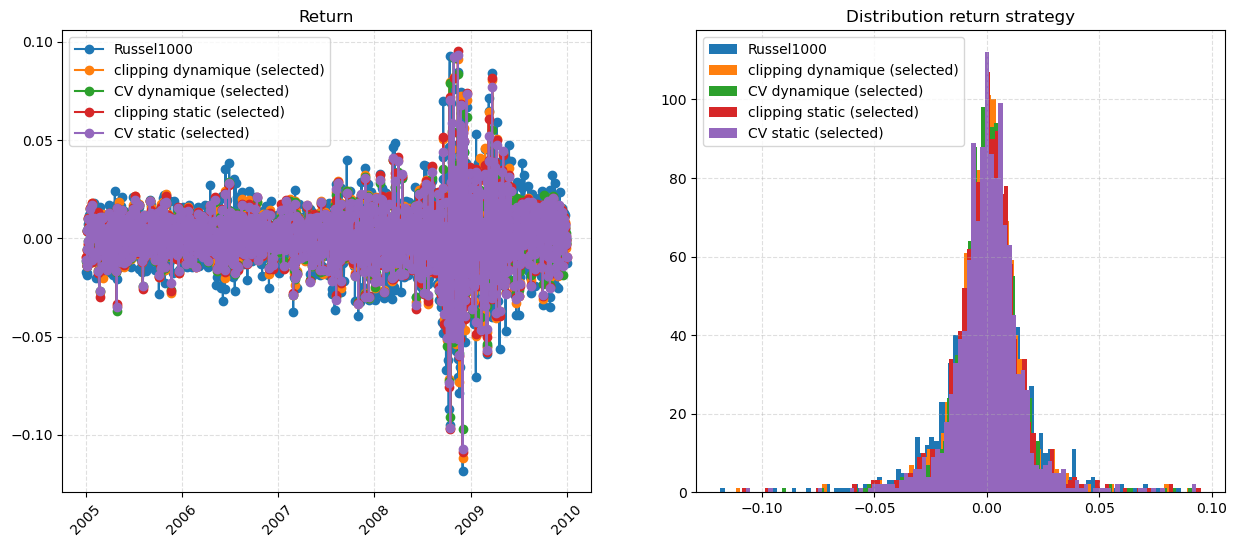

In [38]:
backtest_strategy({"Russel1000":russell_return_outsample,
                   "clipping dynamique (selected)":ptf_return_clipping_dynamique,
                   "CV dynamique (selected)":ptf_return_cv_dynamique,
                   "clipping static (selected)":ptf_return_clipping_statique_selected,
                   "CV static (selected)":ptf_return_cv_statique_selected
                   })



## Turnover

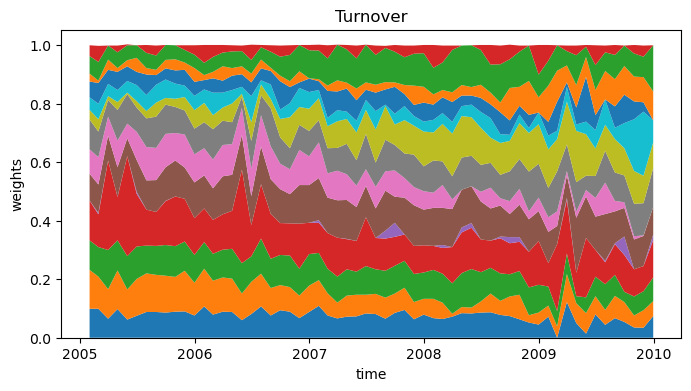

In [39]:
######################## Clipping #######################
turnover(rebalancing_dates, list_weights_clipping)

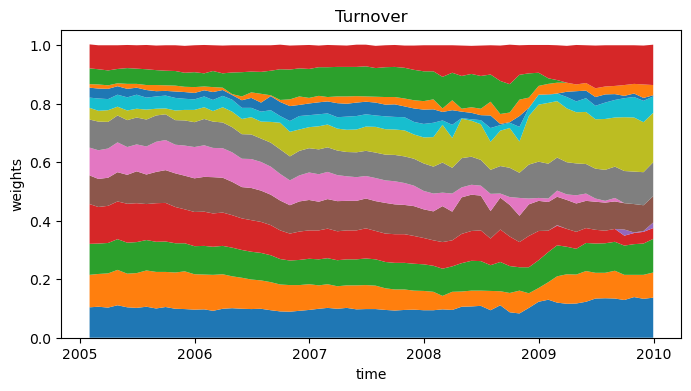

In [40]:
######################## CV #######################
turnover(rebalancing_dates, list_weights_cv)

**Similarly, we have a low turnover, which lowers transaction costs.**

## 3- Conclusion

Let's compare the 3 dynamic portfolios (robust/clipping and cross validation)

/var/folders/s2/myvbmwhd6_q3sbxkqwg5whp80000gn/T/ipykernel_24427/3911208565.py:16: RuntimeWarning: invalid value encountered in double_scalars
  annualized_return = (1 + total_return) ** (facteur_annnualisation/len(df_return)) - 1


      ############################## Backtesting ##############################

                         Start Date: 2005-01-03
                         End Date  : 2009-12-31
                         Nb jours  : 1259


Total Return Russel1000: -104.02%
Total Return clipping dynamique (selected): -74.73%
Total Return CV dynamique (selected): -72.25%
Total Return robust dynamique (selected): -79.07%

Annualized Return Russel1000: nan%
Annualized Return clipping dynamique (selected): -24.09%
Annualized Return CV dynamique (selected): -22.65%
Annualized Return robust dynamique (selected): -26.88%

Daily Volatility Russel1000: 1.88%
Daily Volatility clipping dynamique (selected): 1.57%
Daily Volatility CV dynamique (selected): 1.41%
Daily Volatility robust dynamique (selected): 1.27%

Annualized Volatility Russel1000: 29.83%
Annualized Volatility clipping dynamique (selected): 24.91%
Annualized Volatility CV dynamique (selected): 22.45%
Annualized Volatility robust dynamique (selected): 2

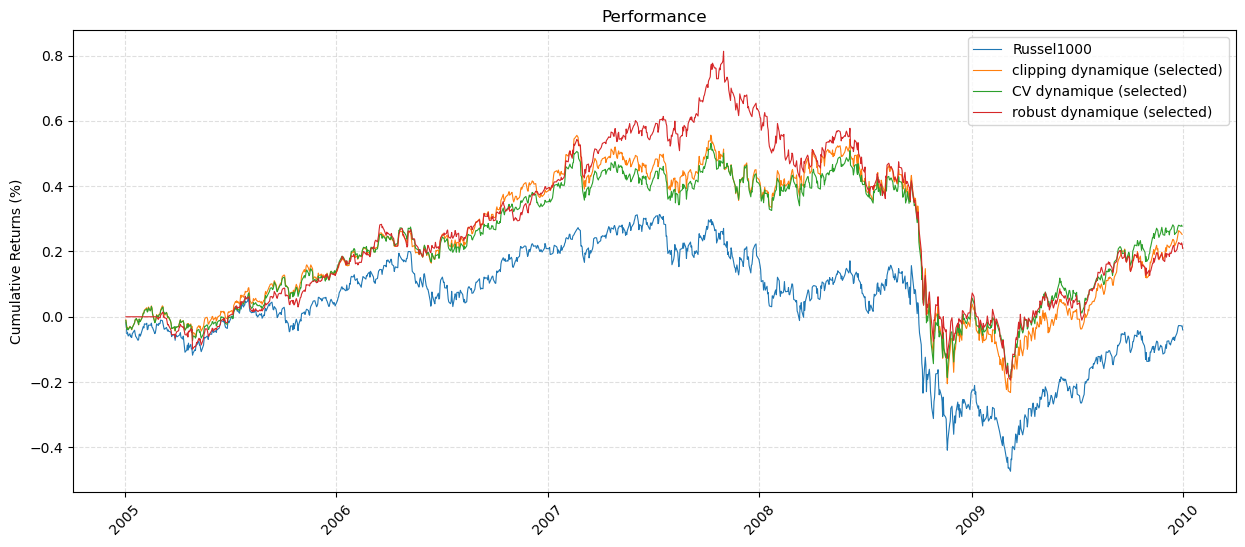

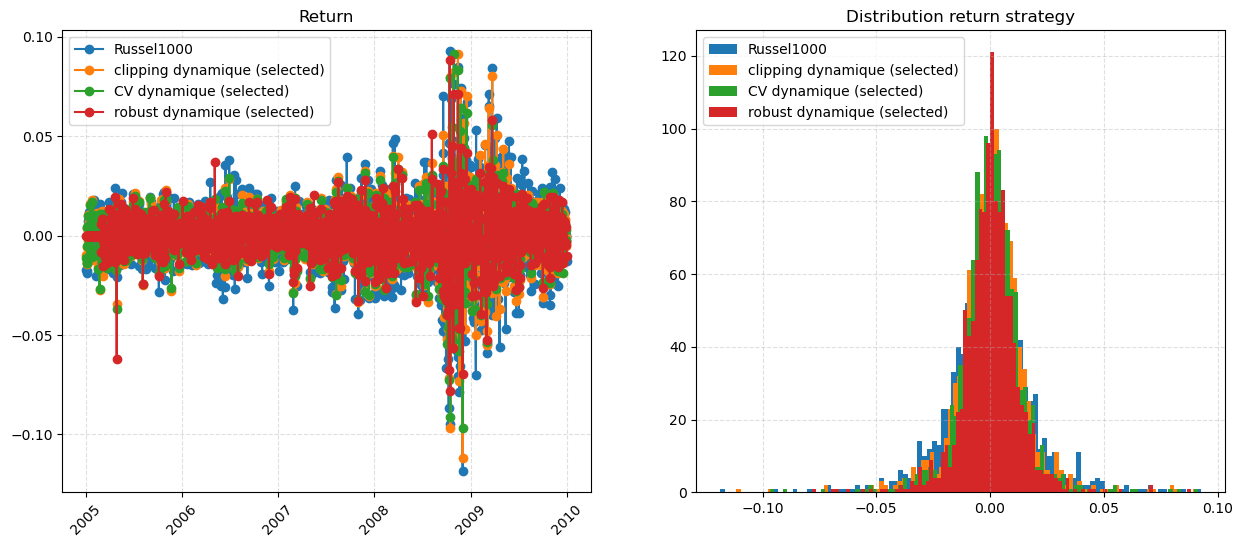

In [41]:
backtest_strategy({"Russel1000":russell_return_outsample,
                   "clipping dynamique (selected)":ptf_return_clipping_dynamique,
                   "CV dynamique (selected)":ptf_return_cv_dynamique,
                   "robust dynamique (selected)":ptf_return_rob_dynamique_selected,
                   })


**All 3 methods superforme the russell1000.** 

**We observe that the filtered matrix methods work better in our case.**

**However, robust optimization is much less risky. Indeed, the robust portfolio has the lowest volatility and the smallest max-drawdown. It is more resistant to crises as shown by the example of the 2008 crisis.**

**Thus the choice of one method or another depends on the risk aversion of the portfolio manager.**